In [46]:
import numpy as np
import pandas as pd 
import geopandas as gpd
import hvplot as hv
import hvplot.pandas
import sys, os
import matplotlib.pyplot as plt
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))  # parent of notebooks
if project_root not in sys.path:
    sys.path.append(project_root)
    
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

from src.util.model import eval_model, prep_data
seed = 42

In [2]:
dff0 = pd.DataFrame()

data_fp = "../../data/training_data"
for fn in os.listdir(data_fp):
    df = pd.read_csv(os.path.join(data_fp, fn))
    print(f"{fn} {df.shape}")
    dff0 = pd.concat([dff0, df])
print(dff0.shape)

snow_2020-2025_p134_fxx1.csv (116216, 68)
snow_2020-2025_p198_fxx1.csv (145920, 68)
snow_2020-2025_p192_fxx1.csv (145920, 68)
snow_2020-2025_p193_fxx1.csv (145920, 68)
snow_2020-2025_p202_fxx1.csv (145920, 68)
snow_2020-2025_p153_fxx1.csv (145920, 68)
snow_2020-2025_p182_fxx1.csv (145920, 68)
snow_2020-2025_p183_fxx1.csv (145920, 68)
snow_2020-2025_p186_fxx1.csv (145920, 68)
snow_2020-2025_p121_fxx1.csv (145920, 68)
snow_2020-2025_p207_fxx1.csv (145920, 68)
snow_2020-2025_p206_fxx1.csv (145920, 68)
snow_2020-2025_p105_fxx1.csv (145920, 68)
snow_2020-2025_p200_fxx1.csv (145920, 68)
snow_2020-2025_p119_fxx1.csv (145920, 68)
snow_2020-2025_p151_fxx1.csv (145920, 68)
(2305016, 68)


In [3]:
danger_levels = pd.read_csv("../../../data/FAC/FAC_Danger_rating_zone_elv.csv")
danger_levels['date'] = pd.to_datetime(danger_levels['date'])
danger_levels = danger_levels[danger_levels['lower'] > -1]
danger_levels = danger_levels.drop_duplicates()
print(danger_levels.shape)
print(danger_levels.head())

(4033, 7)
        date     id  danger_rating forecast_zone_id  lower  upper  middle
0 2020-10-19  90469              0         flathead      0      0       0
1 2020-10-20  90469              0         flathead      0      0       0
2 2020-10-21  90469              0         flathead      0      0       0
3 2020-10-22  90469              0         flathead      0      0       0
4 2020-10-23  90469              0         flathead      0      0       0


In [40]:
X, y = prep_data(
    dff0, 
    danger_levels, 
    replace_missing=True, 
    change_danger=True,
    exclude_cols=['date','id','slope_azi', 'danger_level','altitude','slope_angle']) 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed)

In [ ]:
# Train on data from 4 ids (~25% split)
X_train = X[~X['id_x'].isin(X['id_x'].unique()[:4])]
y_train = y.iloc[X_train.index]

print(X_train.shape, y_train.shape)

X_test = X[X['id_x'].isin(X['id_x'].unique()[:4])]
y_test = y.iloc[X_test.index]

print(X_test.shape, y_test.shape)

(48396, 62) (48396,)
(15331, 62) (15331,)


In [41]:
# Params found from tuning
# {'class_weight': 'balanced', 
#  'max_depth': 50, 
#  'max_features': 0.5, 
#  'min_samples_leaf': 4, 
#  'min_samples_split': 20, 
#  'n_estimators': 1000}


rf = RandomForestClassifier(random_state=seed, n_jobs=-1,
                            max_depth=50,
                            max_features=0.5,
                            min_samples_leaf=4,
                            min_samples_split=20,
                            n_estimators=500,
                            class_weight='balanced'
                           )


rf.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,50
,min_samples_split,20
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Train
Accuracy 0.86
Balanced Accuracy 0.90
MSE: 0.17239060258249642
RMSE: 0.4151994732444833
MAE: 0.15104913916786228
Test
Accuracy 0.78
Balanced Accuracy 0.83
MSE: 0.25822480255243474
RMSE: 0.5081582455814672
MAE: 0.22935299963387207


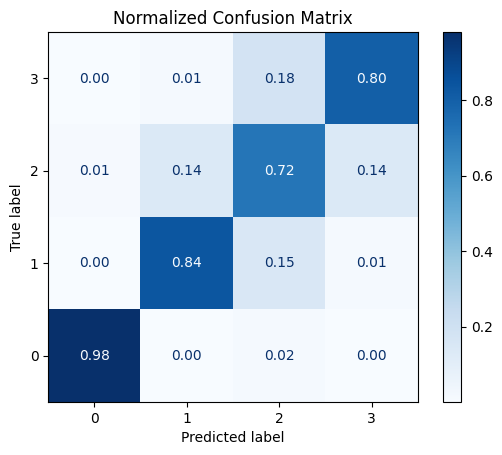

In [42]:
y_pred = rf.predict(X_test)

print("Train")
eval_model(y_train, rf.predict(X_train))

print("Test")
eval_model(y_test, y_pred, plot=True, norm=True)

In [45]:
feature_importances = pd.DataFrame(rf.feature_importances_,index = X_train.columns, columns=["importance"]).sort_values(by="importance", ascending=False)
print(feature_importances[feature_importances['importance'] > 0])

                      importance
mAlbedo                 0.133480
ISWR_diff               0.057413
TA                      0.048302
wind_trans24            0.044569
HN72_24                 0.044303
HS_mod                  0.042913
SWE                     0.042348
MS_Water                0.031245
HS_meas                 0.021096
RH                      0.020084
ski_pen                 0.020079
pAlbedo                 0.019726
dIntEnergySnow          0.018077
S5                      0.017383
ISWR_h                  0.017199
PSUM24                  0.017027
zSn                     0.016623
id_x                    0.015847
HN24                    0.014322
TSS_mod                 0.014212
OLWR                    0.013983
ISWR_dir                0.013813
DW                      0.013609
zS4                     0.013376
zSs                     0.013327
S4                      0.013181
ISWR                    0.012953
ColdContentSnow         0.012745
Ss                      0.012552
Qg0       

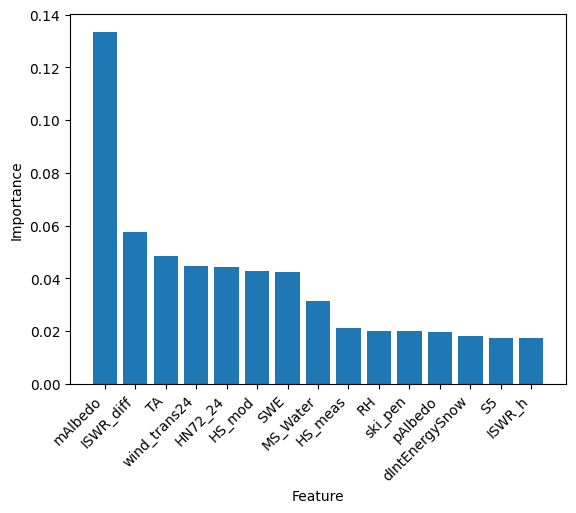

In [57]:
top = feature_importances.iloc[:15]
# plt.figure(figsize=(12,12),dpi=100)
plt.bar(x=top.index, height=top['importance'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

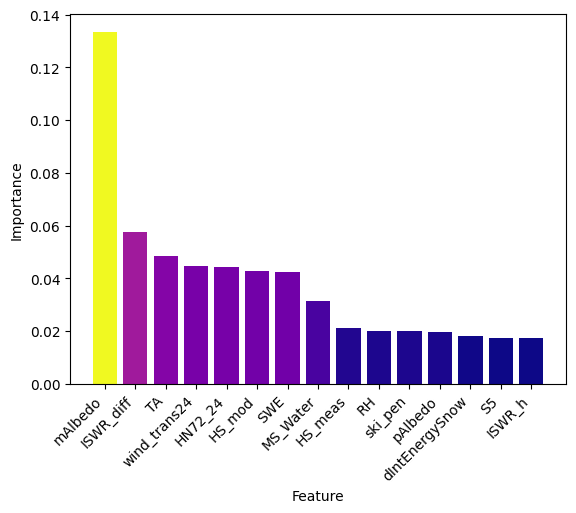

In [76]:
# Normalize and create colors
norm = plt.Normalize(top['importance'].min(), top['importance'].max())
cmap = plt.cm.plasma
colors = cmap(norm(top['importance']))

# Create figure and axes
fig, ax = plt.subplots()

bars = ax.bar(top.index, top['importance'], color=colors)

# Add colorbar — note the ax parameter
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Required for colorbar
# fig.colorbar(sm, ax=ax, label='Importance')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()